# Week 6: Final Project -- Image Classification

In this project, I'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. I'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  I'll get to apply what you learned and build a convolutional, max pooling, dropout, and fully connected layers.  At the end, I'll get to see your neural network's predictions on the sample images.

In [ ]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile


## Step 1
**Gather data, determine the method of data collection and provenance of the data**

In [20]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/input/cifar-10/python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Step 2
**Identify a Deep learning Problem**

In this project, I will classify images into 5 different classes: airplanes, dogs, cats, and other objects.

## Step 3
**Exploratory data analysis (EDA) - INspect, Visualize, clean the data**

The dataset is broken into batches to prevent my machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


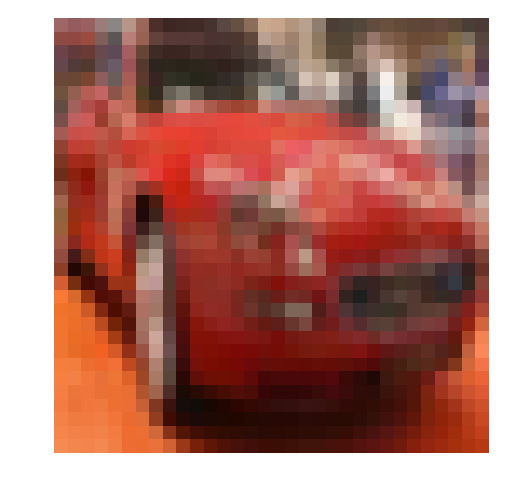

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 5
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

### Normalize
In the cell below, I'll implement the `normalize` function to take in image data, `x`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `x`.

In [ ]:
import tensorflow as tf
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # TODO: Implement Function
    a = 0.
    b = 1.
    grayscale_min=0
    grayscale_max=255
    return a + (((x - grayscale_min)*(b-a)/(grayscale_max-grayscale_min)))


### One-hot encode
I'll implement the `one_hot_encode` function. The input, `x`, are a list of labels.  Implement the function to return the list of labels as One-Hot encoded Numpy array.  The possible values for labels are 0 to 9. The one-hot encoding function returns the same encoding for each value between each call to `one_hot_encode`.  

In [ ]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    # TODO: Implement Function
    one_hot_labels = np.zeros((len(x),10))
    for i in range(len(x)):
        label = x[i]
        one_hot_labels[i,label] = 1
    return one_hot_labels


## Step 4
**Perform Analysis Using deep learning models, present dicussino, and conclusion**

In [ ]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    input_data = tf.placeholder(tf.float32, (None, 32,32,3), name='x')
    return input_data


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    label = tf.placeholder(tf.float32, (None, 10), name='y')
    return label


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    keep_prop = tf.placeholder(tf.float32,name='keep_prob')
    return keep_prop


### Convolution and Max Pooling Layer


In [ ]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """

    height = conv_ksize[0]
    width = conv_ksize[1]
    depth = x_tensor.shape.as_list()[3]
    
    # Convolution layer
    weights = tf.Variable(tf.truncated_normal((height, width, depth , conv_num_outputs)))
   
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    
    padding = 'SAME'
    conv_value = conv_strides[0]
    conv_strides = [1, conv_value, conv_value, 1]
    x_tensor = tf.nn.conv2d(x_tensor, weights, conv_strides, padding) + bias
   
    # Add a nonlinear activation
    x_tensor = tf.nn.relu(x_tensor)
    
    # Pooling layer
    pool_k_value = pool_ksize[0]
    pool_ksize=[1, pool_k_value, pool_k_value, 1]
    
    pool_strides_val = pool_strides[0]
    pool_strides = [1, pool_strides_val, pool_strides_val, 1]
    x_tensor = tf.nn.max_pool(x_tensor, pool_ksize, pool_strides, padding)
    
    return x_tensor


### Flatten Layer


In [ ]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    _, height, width, depth = x_tensor.shape.as_list()
 
    x_tensor = tf.reshape(x_tensor,[-1, height*width*depth])
    return x_tensor


### Fully-Connected Layer


In [ ]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    x_tensor = tf.layers.dense(x_tensor, num_outputs)
    x_tensor = tf.nn.relu(x_tensor)
    return x_tensor


### Output Layer


In [ ]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    x_tensor = tf.layers.dense(x_tensor, num_outputs)
    return x_tensor

### Create Convolutional Model


In [ ]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    
    conv1_max1 = conv2d_maxpool(x, 32, [5,5], [1,1],[2,2],[2,2])
    conv2_max2 = conv2d_maxpool(x, 64, [3,3], [1,1],[2,2],[2,2])
    conv3_max3 = conv2d_maxpool(x, 128, [3,3], [1,1],[2,2],[2,2])
    conv3_max3 = tf.nn.dropout(conv3_max3, keep_prob)

    flat1 = flatten(conv3_max3)

    fc1 = fully_conn(flat1, 128)
    fc2 = fully_conn(fc1, 64)
    fc3 = fully_conn(fc2, 32)

    output1 = output(fc3, 10)

    return output1


# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')


### Train the Neural Network


In [ ]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    
    op = session.run(optimizer, feed_dict={
           x: feature_batch,
           y: label_batch,
           keep_prob: keep_probability[0]})


### Show Stats


In [33]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    
    loss = session.run(cost, feed_dict={
        x: feature_batch,
        y: label_batch,
        keep_prob: 1.0
    })
    acc = session.run(accuracy, feed_dict={
        x: valid_features,
        y: valid_labels,
        keep_prob: 1.0
    })
    print("Loss: " + str(loss))
    print("Accuracy: " + str(acc))

### Hyperparameters
Tune the following parameters: epochs, batch_size, keep_probability


In [1]:
epochs = 20
batch_size = 128
keep_probability = [0.75]

### Train on a Single CIFAR-10 Batch


In [35]:

print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        print(epoch)
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
0
Epoch  1, CIFAR-10 Batch 1:  Loss: 2.39778
Accuracy: 0.2718
1
Epoch  2, CIFAR-10 Batch 1:  Loss: 1.96356
Accuracy: 0.3374
2
Epoch  3, CIFAR-10 Batch 1:  Loss: 1.76649
Accuracy: 0.353
3
Epoch  4, CIFAR-10 Batch 1:  Loss: 1.35473
Accuracy: 0.4252
4
Epoch  5, CIFAR-10 Batch 1:  Loss: 1.25275
Accuracy: 0.4136
5
Epoch  6, CIFAR-10 Batch 1:  Loss: 1.07341
Accuracy: 0.4738
6
Epoch  7, CIFAR-10 Batch 1:  Loss: 0.998626
Accuracy: 0.465
7
Epoch  8, CIFAR-10 Batch 1:  Loss: 0.949104
Accuracy: 0.479
8
Epoch  9, CIFAR-10 Batch 1:  Loss: 0.819232
Accuracy: 0.4924
9
Epoch 10, CIFAR-10 Batch 1:  Loss: 0.798189
Accuracy: 0.4766
10
Epoch 11, CIFAR-10 Batch 1:  Loss: 0.753176
Accuracy: 0.4968
11
Epoch 12, CIFAR-10 Batch 1:  Loss: 0.638023
Accuracy: 0.502
12
Epoch 13, CIFAR-10 Batch 1:  Loss: 0.569772
Accuracy: 0.513
13
Epoch 14, CIFAR-10 Batch 1:  Loss: 0.515891
Accuracy: 0.5236
14
Epoch 15, CIFAR-10 Batch 1:  Loss: 0.491194
Accuracy: 0.519
15
Epoch 16, CIFAR-

### Fully Train the Model


In [37]:

save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss: 2.03597
Accuracy: 0.2368
Epoch  1, CIFAR-10 Batch 2:  Loss: 1.88827
Accuracy: 0.3182
Epoch  1, CIFAR-10 Batch 3:  Loss: 1.54299
Accuracy: 0.3888
Epoch  1, CIFAR-10 Batch 4:  Loss: 1.36348
Accuracy: 0.4612
Epoch  1, CIFAR-10 Batch 5:  Loss: 1.36073
Accuracy: 0.4796
Epoch  2, CIFAR-10 Batch 1:  Loss: 1.63417
Accuracy: 0.4154
Epoch  2, CIFAR-10 Batch 2:  Loss: 1.26238
Accuracy: 0.501
Epoch  2, CIFAR-10 Batch 3:  Loss: 0.995432
Accuracy: 0.4972
Epoch  2, CIFAR-10 Batch 4:  Loss: 1.08205
Accuracy: 0.539
Epoch  2, CIFAR-10 Batch 5:  Loss: 1.13831
Accuracy: 0.5502
Epoch  3, CIFAR-10 Batch 1:  Loss: 1.27398
Accuracy: 0.512
Epoch  3, CIFAR-10 Batch 2:  Loss: 0.890371
Accuracy: 0.5488
Epoch  3, CIFAR-10 Batch 3:  Loss: 0.802283
Accuracy: 0.5276
Epoch  3, CIFAR-10 Batch 4:  Loss: 1.02015
Accuracy: 0.5616
Epoch  3, CIFAR-10 Batch 5:  Loss: 0.995188
Accuracy: 0.5764
Epoch  4, CIFAR-10 Batch 1:  Loss: 1.09749
Accuracy: 0.5834
Epoch  4, CIFAR-10 Batch 2:


## Test Model
Test the model against the test dataset.  

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.6313291139240507



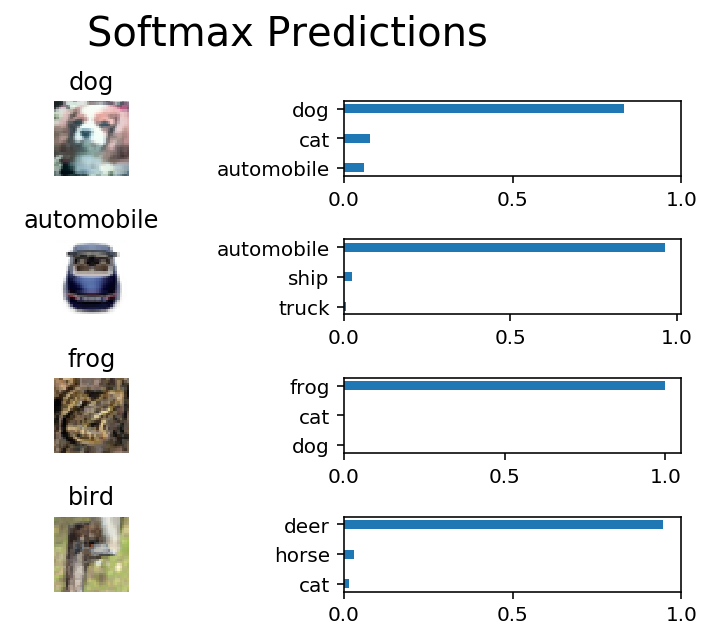

In [39]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

## Discussion and Conclusion
In this project, I successfully train CNN model to classify images into 5 differnent classes. I got 64.7% on validation set and 63.1% on test set. 